# LSH算法

## 1.LSH 算法原理分步详解

**🧩 LSH 算法原理分步详解（Locality-Sensitive Hashing）**

---

### 一、核心思想

> **目的**：在高维空间中快速找到“相似”的数据点。  
> **关键思想**：让相似的样本在哈希后 **落入同一个桶（bucket）** 的概率高，不相似的样本落入同桶的概率低。

相比暴力搜索（O(N)），LSH 通过 **多组随机哈希函数** 将搜索复杂度降低到 **亚线性（sublinear）**。

---

### 二、适用场景

| 相似度度量 | 常用 LSH 变体 | 哈希思想 |
|-------------|----------------|-----------|
| 余弦相似度（cosine similarity） | Random Projection LSH | 用随机超平面划分空间 |
| 欧式距离（L2 distance） | p-stable LSH | 用随机投影 + 模运算近似欧氏距离 |
| Jaccard 相似度（集合相似度） | MinHash LSH | 利用最小哈希值近似集合交并比 |

---

### 三、算法原理分步讲解（以余弦相似度为例）

#### 第 1 步：构建随机超平面（Random Hyperplanes）

- 在 d 维空间随机生成 k 个向量，这些向量充当超平面的**法向量（Normal Vector）**。
  $$
  ( r_1, r_2, \ldots, r_k )
  $$
  每个向量的分量服从标准正态分布
  $$
   N(0,1) 
  $$
  
- 每个随机向量 $r_i$ 唯一确定了一个经过原点且与其垂直的超平面。我们通过判断数据点位于该超平面的哪一侧来进行哈希编码。

---

#### 第 2 步：计算哈希签名（Hash Signature）

对于一个向量 $x$，我们计算它与 $k$ 个超平面的法向量 $r_i$ 的点积。根据点积结果的正负，生成对应的二进制位：

$$
h_i(x) =
\begin{cases}
1, & \text{if } r_i \cdot x \ge 0 \\
0, & \text{otherwise}
\end{cases}
$$

将这 $k$ 个结果拼接起来，就形成了一个长度为 $k$ 的二进制串（例如 `10100110`）。这个二进制串就是向量 $x$ 的 **哈希签名**。

> ✅ **直觉**：两个向量的夹角越小，被随机超平面分开的概率越低（更可能在同侧），因此哈希签名越相似。

---

#### 第 3 步：构建多个哈希表（Multi-Table Strategy）

- 为了减少碰撞错误（不同向量哈希相同），我们使用多组独立哈希函数。
- 假设有：
  - 每组 k 个哈希函数组成一个 **哈希表（hash table）**。在每个哈希表中，**哈希签名**（即那个 $k$ 位二进制串）相同的向量，会被放在一起，形成一个“哈希桶”。
  - 共 L 个这样的表。

每个样本被插入到 $L$ 个哈希表对应的桶中，从而提升召回率。

---

#### 第 4 步：查询（Query）

给定查询向量 $q$：

1. 计算 $q$ 在 $L$ 个哈希表中的签名；
2. 找出这 $L$ 个表中所有对应 **“桶”** 里的向量，合并作为候选集；
3. 对候选集中的向量计算真实相似度（如余弦或欧式距离）；
4. 返回相似度最高的 Top-K。

---

### 四、参数与性能权衡

| 参数 | 含义 | 影响 |
|------|------|------|
| k | 每组哈希函数数量 | 越大 → 桶更小，召回率下降但精度提高 |
| L | 哈希表数量 | 越多 → 召回率上升但内存消耗大 |
| n | 样本数量 | 影响查询速度，越多收益越明显 |

一般经验值：
- **k** = 10～20  
- **L** = 20～100  

---

### 五、算法复杂度分析

| 阶段 | 时间复杂度 | 空间复杂度 |
|------|-------------|-------------|
| 建表 |  $O(nLk)$  |  $O(nL)$  |
| 查询 |  $O(L(k + c))$ ，其中 c 为候选数量 | - |

相比暴力搜索  $O(n)$ ，LSH 查询复杂度可达 **亚线性级（如 $O(n^{0.5})$）**。

---



## 2.LSH算法实现

🧠 LSH算法Python实现

In [1]:
import numpy as np
from typing import List, Union, Dict


class CosineLSH:
    """
    基于随机超平面投影的局部敏感哈希（LSH），适用于余弦相似度测量。
    
    参数:
        hash_size (int): 单个哈希表的哈希函数数量（即哈希码的位数）
        num_tables (int): 使用的哈希表数量
    """
    
    def __init__(self, hash_size: int = 6, num_tables: int = 5):
        self.hash_size = hash_size  # 每个哈希表的位数
        self.num_tables = num_tables  # 哈希表数量
        self.hash_tables = [dict() for _ in range(num_tables)]  # 初始化哈希表
        self.random_planes_list = []  # 存储每个哈希表的随机超平面
        self.dimension = None  # 数据维度（在插入数据时确定）
        self.data = None  # 存储数据向量（便于后续使用和调试）
    
    def _generate_random_planes(self, dimension: int) -> np.ndarray:
        """为单个哈希表生成随机超平面（每个超平面对应一个哈希函数）"""
        return np.random.randn(self.hash_size, dimension)
    
    def _hash(self, vector: np.ndarray, random_planes: np.ndarray) -> str:
        """计算单个向量的哈希键（二进制字符串）"""
        # 计算向量与每个随机超平面的点积，根据符号生成二进制位
        projections = np.dot(vector, random_planes.T)
        hash_bits = (projections > 0).astype(int)  # 大于0为1，否则为0
        return ''.join(hash_bits.astype(str))  # 转换为二进制字符串作为哈希键
    
    def index(self, data: Union[List[List[float]], np.ndarray]) -> None:
        """
        将数据向量插入LSH索引中
        
        参数:
            data: 待索引的向量列表或数组
        """
        data_array = np.array(data)
        if len(data_array.shape) == 1:
            data_array = data_array.reshape(1, -1)
        
        self.dimension = data_array.shape[1]  # 设置数据维度
        self.data = data_array  # 存储数据（便于后续使用和调试）
        
        # 为每个哈希表生成随机超平面
        self.random_planes_list = [
            self._generate_random_planes(self.dimension) 
            for _ in range(self.num_tables)
        ]
        
        # 将每个向量插入所有哈希表
        for i, vector in enumerate(data_array):
            for table_idx in range(self.num_tables):
                hash_key = self._hash(vector, self.random_planes_list[table_idx])
                
                # 将向量索引存入对应哈希桶
                if hash_key in self.hash_tables[table_idx]:
                    self.hash_tables[table_idx][hash_key].append(i)
                else:
                    self.hash_tables[table_idx][hash_key] = [i]
    
    def query(self, query_vector: Union[List[float], np.ndarray], 
              max_results: int = 10, 
              return_all_candidates: bool = False,
              sort_by_distance: bool = False,
              return_distances: bool = False):
        """
        查询与给定向量相似的向量
        
        参数:
            query_vector: 查询向量
            max_results: 返回的最大结果数量（当return_all_candidates=False时生效）
            return_all_candidates: 是否返回所有候选向量（默认False）
            sort_by_distance: 是否按距离排序（默认False）
            return_distances: 是否返回距离（默认False）
            
        返回:
            如果return_distances=False: 相似向量的索引列表
            如果return_distances=True: (索引列表, 距离数组) 的元组
        """
        if self.dimension is None:
            raise ValueError("请先使用index方法插入数据")
        
        query_vec = np.array(query_vector)
        candidates = set()
        
        # 在所有哈希表中查找候选向量
        for table_idx in range(self.num_tables):
            hash_key = self._hash(query_vec, self.random_planes_list[table_idx])
            if hash_key in self.hash_tables[table_idx]:
                candidates.update(self.hash_tables[table_idx][hash_key])
        
        # 如果没有找到候选向量，尝试查找邻近桶
        if not candidates:
            print("未找到精确匹配的候选向量，正在搜索邻近桶...")
            for table_idx in range(self.num_tables):
                original_key = self._hash(query_vec, self.random_planes_list[table_idx])
                # 查找哈希码只有1位不同的桶
                for i in range(self.hash_size):
                    neighbor_key = list(original_key)
                    neighbor_key[i] = '1' if neighbor_key[i] == '0' else '0'
                    neighbor_key = ''.join(neighbor_key)
                    if neighbor_key in self.hash_tables[table_idx]:
                        candidates.update(self.hash_tables[table_idx][neighbor_key])
        
        if not candidates:
            if return_distances:
                return np.array([], dtype=int), np.array([])
            return []
        
        cand_ids = np.array(list(candidates), dtype=int)
        
        # 如果需要排序，计算距离并排序
        if sort_by_distance:
            dists = np.linalg.norm(self.data[cand_ids] - query_vec, axis=1)
            sorted_indices = np.argsort(dists)
            cand_ids = cand_ids[sorted_indices]
            if return_distances:
                dists = dists[sorted_indices]
        
        # 决定返回多少个结果
        if not return_all_candidates:
            cand_ids = cand_ids[:max_results]
            if sort_by_distance and return_distances:
                dists = dists[:max_results]
        
        if return_distances:
            return cand_ids, dists
        return list(cand_ids)
    
    def get_hash_tables_info(self) -> Dict:
        """返回哈希表的统计信息"""
        info = {
            'num_tables': self.num_tables,
            'hash_size': self.hash_size,
            'total_buckets': 0,
            'average_bucket_size': 0,
            'table_details': []
        }
        
        total_vectors = 0
        for i, table in enumerate(self.hash_tables):
            num_buckets = len(table)
            vectors_in_table = sum(len(bucket) for bucket in table.values())
            total_vectors += vectors_in_table
            
            avg_size = vectors_in_table / num_buckets if num_buckets > 0 else 0
            info['table_details'].append({
                'table_index': i,
                'num_buckets': num_buckets,
                'total_vectors': vectors_in_table,
                'average_bucket_size': avg_size
            })
        
        info['total_buckets'] = sum(detail['num_buckets'] 
                                  for detail in info['table_details'])
        if info['total_buckets'] > 0:
            info['average_bucket_size'] = (total_vectors / 
                                         info['total_buckets'])
        
        return info
    
    def query_with_topk(self, query_vector: Union[List[float], np.ndarray], k: int = 5):
        """
        查询并返回候选集和Top-k结果（便捷方法，用于可视化）
        
        参数:
            query_vector: 查询向量
            k: 返回的Top-k数量
            
        返回:
            (候选ID数组, Top-k ID数组) 的元组
        """
        # 获取所有候选向量
        all_candidates = self.query(query_vector, return_all_candidates=True, sort_by_distance=False)
        
        if len(all_candidates) == 0:
            return np.array([], dtype=int), np.array([], dtype=int)
        
        # 计算Top-k
        cand_ids = np.array(all_candidates, dtype=int)
        dists = np.linalg.norm(self.data[cand_ids] - np.array(query_vector), axis=1)
        topk = cand_ids[np.argsort(dists)[:k]]
        
        return cand_ids, topk
    
    def _query_single_table(self, query_vec, table_idx):
        """查询单张哈希表，返回候选点ID集合（用于可视化）"""
        hash_key = self._hash(query_vec, self.random_planes_list[table_idx])
        return set(self.hash_tables[table_idx].get(hash_key, []))
    
    def _compute_topk_from_candidates(self, query_vec, candidate_ids, k):
        """从候选集中计算Top-k最近邻（用于可视化）"""
        if len(candidate_ids) == 0:
            return np.array([], dtype=int)
        dists = np.linalg.norm(self.data[candidate_ids] - query_vec, axis=1)
        return candidate_ids[np.argsort(dists)[:k]]
    
    def compute_matches(self, query_vec):
        """
        计算所有数据点与查询点的哈希匹配情况（用于可视化）
        
        返回:
            bits: 数据点哈希编码 (N, L, Bits)
            q_bits: 查询点哈希编码 (L, Bits)
            matches: 每个点在每张表是否匹配 (N, L)
            hit_counts: 每个点命中的表数 (N,)
            candidates: 至少命中一张表的点索引
        """
        if self.data is None:
            raise ValueError("请先使用index方法插入数据")
        
        # 将random_planes_list转换为(n_tables, hash_size, dimension)格式
        planes = np.array(self.random_planes_list)  # (num_tables, hash_size, dimension)
        
        # 计算投影: (N, num_tables, hash_size)
        proj = np.dot(self.data, planes.transpose(0, 2, 1))
        q_proj = np.dot(query_vec, planes.transpose(0, 2, 1))
        
        bits = proj > 0
        q_bits = q_proj > 0
        matches = np.all(bits == q_bits, axis=2)
        hit_counts = matches.sum(axis=1)
        return bits, q_bits, matches, hit_counts, np.where(hit_counts > 0)[0]
    
    @property
    def planes(self):
        """返回超平面数组，格式为 (num_tables, hash_size, dimension)（用于可视化兼容性）"""
        if len(self.random_planes_list) == 0:
            return None
        return np.array(self.random_planes_list)
    
    @property
    def num_bits(self):
        """返回哈希位数（用于可视化兼容性）"""
        return self.hash_size


# 示例使用和测试
if __name__ == "__main__":
    # 生成示例数据
    np.random.seed(42)  # 设置随机种子以确保结果可重现
    data_vectors = np.random.randn(100, 10)  # 100个10维向量
    
    # 创建LSH索引
    print("正在构建LSH索引...")
    lsh = CosineLSH(hash_size=8, num_tables=3)
    lsh.index(data_vectors)
    
    # 显示哈希表统计信息
    info = lsh.get_hash_tables_info()
    print(f"\n哈希表统计信息:")
    print(f"哈希表数量: {info['num_tables']}")
    print(f"总桶数: {info['total_buckets']}")
    print(f"平均每个桶的向量数: {info['average_bucket_size']:.2f}")
    
    # 查询示例
    query_vec = data_vectors[0]  # 使用第一个向量作为查询
    print(f"\n查询向量索引: 0")
    
    similar_indices = lsh.query(query_vec, max_results=5)
    print(f"找到的相似向量索引: {similar_indices}")
    
    # 验证结果：计算实际余弦相似度
    from sklearn.metrics.pairwise import cosine_similarity
    
    print("\n相似度验证:")
    for idx in similar_indices:
        similarity = cosine_similarity([query_vec], [data_vectors[idx]])[0][0]
        print(f"向量 {idx} 与查询向量的余弦相似度: {similarity:.4f}")
    
    # 对比线性搜索结果
    print("\n=== 与线性搜索对比 ===")
    all_similarities = cosine_similarity([query_vec], data_vectors)[0]
    top_linear = np.argsort(all_similarities)[::-1][1:6]  # 排除自身，取前5个
    print(f"线性搜索Top-5结果: {top_linear}")
    
    # 计算召回率
    lsh_recall = len(set(similar_indices) & set(top_linear)) / len(top_linear)
    print(f"LSH召回率（与真实Top-5相比）: {lsh_recall:.2%}")

正在构建LSH索引...

哈希表统计信息:
哈希表数量: 3
总桶数: 189
平均每个桶的向量数: 1.59

查询向量索引: 0
找到的相似向量索引: [0, 48, 20, 54, 86]

相似度验证:
向量 0 与查询向量的余弦相似度: 1.0000
向量 48 与查询向量的余弦相似度: -0.2653
向量 20 与查询向量的余弦相似度: 0.5041
向量 54 与查询向量的余弦相似度: 0.4609
向量 86 与查询向量的余弦相似度: 0.6143

=== 与线性搜索对比 ===
线性搜索Top-5结果: [91 32 15 86 20]
LSH召回率（与真实Top-5相比）: 40.00%


### 3.LSH算法可视化

LSH算法完整演示
生成198个2维数据点
LSH索引构建完成!

LSH索引统计:
向量总数: 198
哈希表数量: 3
每表哈希位数: 4
总桶数: 21
表1: 7个桶, 平均每个桶28.29个向量
表2: 8个桶, 平均每个桶24.75个向量
表3: 6个桶, 平均每个桶33.00个向量

查询点: [1.5 1.5]
找到66个候选向量:
候选向量0: 距离=0.9782
候选向量1: 距离=1.9974
候选向量2: 距离=0.4422
候选向量3: 距离=2.0858
候选向量4: 距离=0.9423
...

Top-5 最近邻结果:
Top1: 向量42, 距离=0.1768
Top2: 向量5, 距离=0.1815
Top3: 向量46, 距离=0.2457
Top4: 向量51, 距离=0.2667
Top5: 向量14, 距离=0.2674

生成可视化图表...


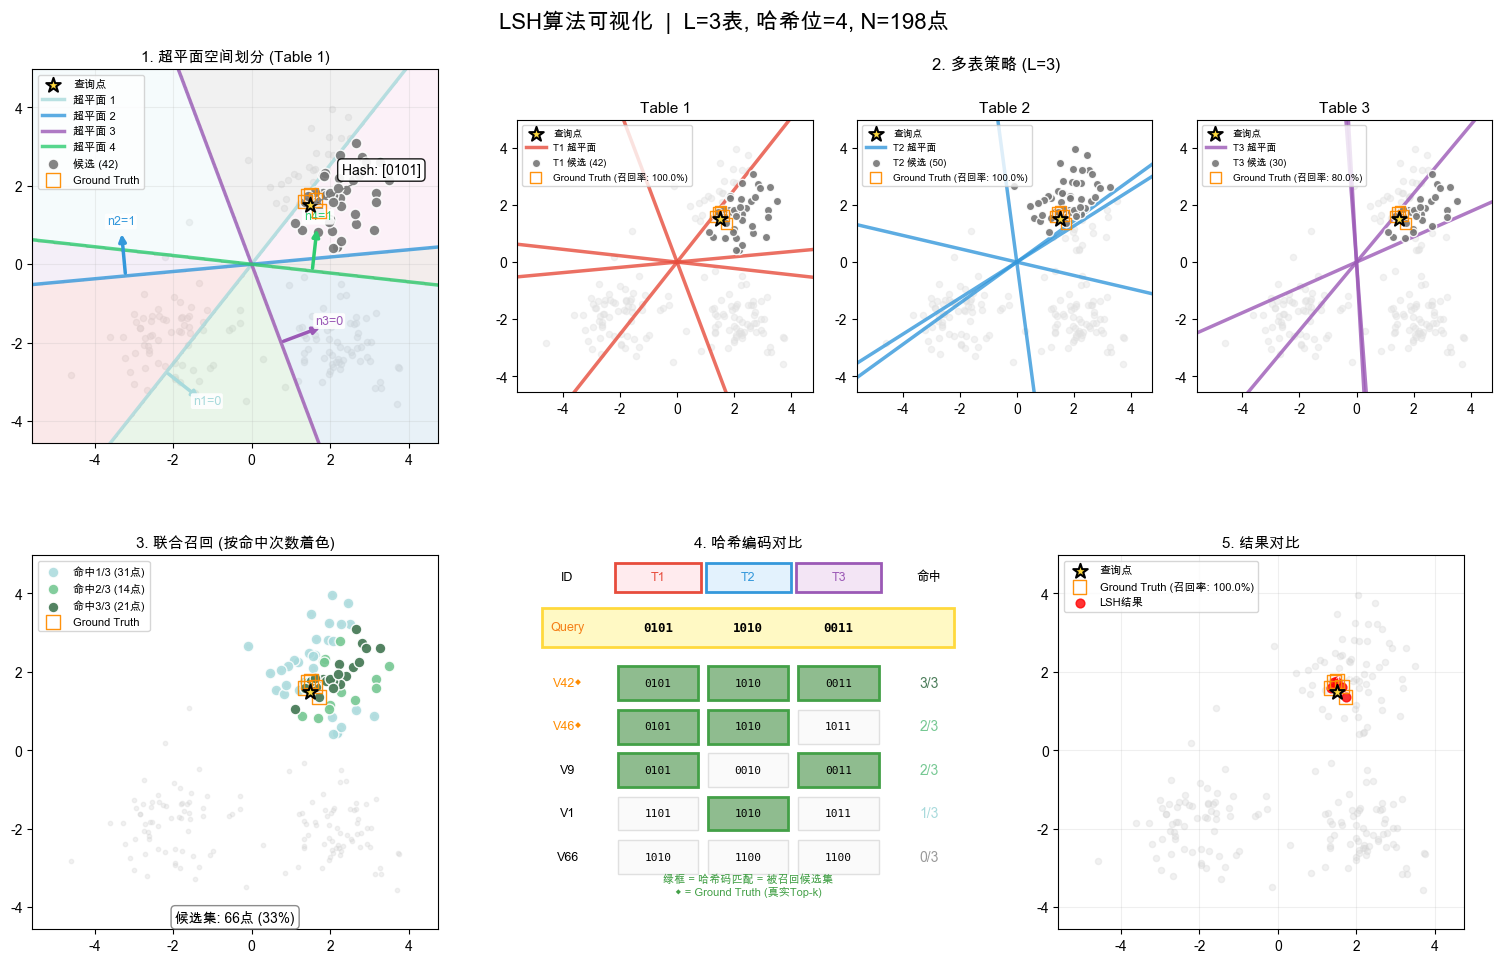


LSH 结果: 召回率=100%, 加速=3.0×



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from pathlib import Path

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 为了后续可视化方便，这里统一配置颜色和绘图配置。
# 颜色配置
COLORS = {
    "data": "#E0E0E0",      # 数据点颜色（浅灰色）
    "query": "#FFD93D",     # 查询点颜色（亮黄色）
    "candidates": "#777777", # 候选点颜色（中灰色）
    "tables": ["#E74C3C", "#3498DB", "#9B59B6"],  # 不同哈希表的颜色标识
    "hits": ["#A8DADC", "#76C893", "#4A7C59"],    # 命中次数对应的颜色渐变
    "planes": ["#A8DADC", "#3498DB", "#9B59B6", "#2ECC71"],  # 超平面颜色循环使用
    "hash_table": {
        "match_bg": "#8FBC8F",      # 哈希码匹配的背景色
        "no_match_bg": "#FAFAFA",  # 哈希码不匹配的背景色
        "match_border": "#43A047", # 哈希码匹配的边框色
        "no_match_border": "#E0E0E0", # 哈希码不匹配的边框色
        "no_hit_text": "#999",     # 未命中时的文字颜色
    },
}

# 绘图配置
PLOT_CONFIG = {
    "figsize": (16, 10),
    "fontsize": {"title": 11, "legend": 8, "text": 10, "suptitle": 16, "panel_title": 12},
    "alpha": {
        "data": 0.4,    # 数据点透明度
        "candidates": 0.9,     # 候选点透明度（较不透明，突出显示）
        "hits": 0.8,           # 命中点透明度（中等透明度）
        "planes": 0.8,         # 超平面透明度（清晰可见但不抢镜）
        "bbox": 0.9,           # 文本框背景透明度
        "grid": 0.2            # 网格线透明度（很淡，只做参考）
    },
    "sizes": {"data": 20, "query": 120, "candidates": 60, "hit_points": 50},
    "ground_truth": {
        "face": "none",        # Ground truth点填充色（空心）
        "edge": "#FF8C00",     # Ground truth点边框色（深橙色）
        "text": "#FF8C00",     # Ground truth文本颜色（深橙色）
        "marker": "s",         # Ground truth点形状（方框）
        "alpha": 0.95,         # Ground truth点透明度
        "size": 100,        # 统一的ground truth点大小
        "linewidth": 1,   # 统一的线条粗细
        "zorder": 8,     # 统一的图层层级
    },
    "grid": {
        "hspace": 0.3,    # 子图垂直间距
        "wspace": 0.25    # 子图水平间距
    },
    "table_wspace": 0.15,  # 多表哈希子图间距
    "contour_resolution": 200,  # 背景网格分辨率
    "save": {"dpi": 150},
    "planes": {
        "linewidth": 2.5,
        "arrow": {          # 超平面法向量箭头定位参数
            "scale": 0.12,   # 箭头大小缩放因子
            "t_min": 0.05,   # 箭头位置最小偏移
            "t_max": 0.33,   # 箭头位置最大偏移
            "t_base": 0.25,  # 箭头位置基础偏移
            "t_step": 0.04   # 多箭头间的偏移步长
        }
    },
    "layout": {
        "subplots_adjust": {  # 子图整体位置调整
            "top": 0.92, "bottom": 0.06, "left": 0.05, "right": 0.98
        }
    }
}




def _line_in_box(w, xlim, ylim):
    """计算超平面 w·x=0 与绘图边界框的交点，返回线段两端点"""
    pts = []
    eps = 1e-12
    # 与左右边界 (x=常数) 求交
    if abs(w[1]) > eps:
        for x in xlim:
            y = -w[0] * x / w[1]
            if ylim[0] - 1e-9 <= y <= ylim[1] + 1e-9:
                pts.append([x, y])
    # 与上下边界 (y=常数) 求交
    if abs(w[0]) > eps:
        for y in ylim:
            x = -w[1] * y / w[0]
            if xlim[0] - 1e-9 <= x <= xlim[1] + 1e-9:
                pts.append([x, y])
    if len(pts) < 2:
        return None
    # 去重：保留第一个点，然后添加与第一个点不接近的点
    unique = [pts[0]]
    for p in pts[1:]:
        if not np.allclose(p, unique[0]):
            unique.append(p)
            if len(unique) >= 2:
                break
    return (np.array(unique[0]), np.array(unique[1])) if len(unique) >= 2 else None

def _draw_hyperplanes(ax, planes, xlim, ylim, query, span, colors, table_idx=0, show_arrows=True):
    """绘制超平面及其标注"""
    for i, p in enumerate(planes):
        seg = _line_in_box(p, xlim, ylim)
        if not seg:
            continue
        p1, p2 = seg

        # Panel 1: 关注不同超平面切分，每个超平面用不同颜色，Panel 2: 关注不同的切分效果，每个表用一种颜色
        color = colors["planes"][i] if show_arrows else colors["tables"][table_idx]
        label = f"超平面 {i+1}" if show_arrows else (f"T{table_idx+1} 超平面" if i == 0 else None)

        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], c=color, lw=PLOT_CONFIG["planes"]["linewidth"], alpha=PLOT_CONFIG["alpha"]["planes"], label=label)

        if show_arrows and table_idx == 0:
            # 绘制法向量箭头（只在Panel 1显示）
            low, high = (p1, p2) if p1[1] <= p2[1] else (p2, p1)
            n_hat = p / (np.linalg.norm(p) + 1e-12)
            side = 1.0 if np.dot(query, p) >= 0 else -1.0
            arrow_config = PLOT_CONFIG["planes"]["arrow"]
            t = np.clip(arrow_config["t_base"] + (i - (len(planes) - 1) / 2) * arrow_config["t_step"], arrow_config["t_min"], arrow_config["t_max"])
            base = low + (high - low) * t
            arrow = side * n_hat * arrow_config["scale"] * span
            ax.annotate("", xy=base + arrow, xytext=base,
                       arrowprops=dict(arrowstyle="-|>", color=color, lw=2.5), zorder=6)
            ax.text(*(base + arrow * 1.15), f"n{i+1}={'1' if side >= 0 else '0'}",
                   fontsize=9, fontweight="bold", c=color, ha="center",
                   bbox=dict(boxstyle="round,pad=0.15", fc="w", ec="none", alpha=PLOT_CONFIG["alpha"]["bbox"]), zorder=7)

def setup_plot(ax, xlim, ylim, data, query, title="", data_alpha=None, data_color=None, data_size=None, query_label=True):
    """统一的绘图设置函数：初始化子图并绘制数据点和查询点"""
    ax.set(xlim=xlim, ylim=ylim, aspect="equal")
    if title:
        ax.set_title(title, fontsize=PLOT_CONFIG["fontsize"]["title"], fontweight="bold")
    
    # 绘制数据点
    ax.scatter(data[:, 0], data[:, 1], 
              c=data_color or COLORS["data"],
              s=data_size or PLOT_CONFIG["sizes"]["data"],
              alpha=data_alpha or PLOT_CONFIG["alpha"]["data"],
              zorder=1)
    
    # 绘制查询点
    ax.scatter(*query, c=COLORS["query"], marker="*", 
              s=PLOT_CONFIG["sizes"]["query"],
              ec="k", lw=1.5, zorder=10,
              label="查询点" if query_label else None)

def draw_candidates(ax, data, matches_or_hits, table_idx=None, lsh=None, size=None, alpha=None, show_prefix=True):
    """绘制候选点：table_idx指定时按表着色，否则按命中次数着色"""
    size = size or PLOT_CONFIG["sizes"]["candidates"]
    alpha = alpha or PLOT_CONFIG["alpha"]["candidates"]
    
    if table_idx is not None:
        # 按表着色
        matches = matches_or_hits
        if matches[:, table_idx].any():
            pts = data[matches[:, table_idx]]
            prefix = f"T{table_idx+1} " if show_prefix else ""
            ax.scatter(pts[:, 0], pts[:, 1], c=COLORS["candidates"], s=size, alpha=alpha,
                      ec="w", lw=1, zorder=5, label=f"{prefix}候选 ({len(pts)})")
    else:
        # 按命中次数着色
        if lsh is None:
            raise ValueError("当table_idx=None时，必须提供lsh参数")
        hits = matches_or_hits
        for h in range(1, lsh.num_tables + 1):
            idx = np.where(hits == h)[0]
            if len(idx):
                ax.scatter(data[idx, 0], data[idx, 1], c=COLORS["hits"][h-1], s=size,
                          alpha=min(PLOT_CONFIG["alpha"]["hits"] + h * 0.05, 1.0),
                          ec="w", lw=1, zorder=h+2, 
                          label=f"命中{h}/{lsh.num_tables} ({len(idx)}点)")

def _setup_legend(ax, fontsize=None, loc="upper left"):
    """统一的图例设置函数"""
    fontsize = fontsize or PLOT_CONFIG["fontsize"]["legend"]
    ax.legend(fontsize=fontsize, loc=loc)

def draw_ground_truth(ax, data, gt_indices, recall=None, size_scale=1.0):
    """ground Truth绘制函数"""
    if gt_indices is None or len(gt_indices) == 0:
        return
    
    gt_config = PLOT_CONFIG["ground_truth"]
    label = f"Ground Truth (召回率: {recall:.1%})" if recall is not None else "Ground Truth"
    ax.scatter(data[gt_indices, 0], data[gt_indices, 1],
              c=gt_config["face"], marker=gt_config["marker"],
              s=gt_config["size"] * size_scale,
              ec=gt_config["edge"], lw=gt_config["linewidth"],
              alpha=gt_config["alpha"], label=label,
              zorder=gt_config["zorder"])


def print_lsh_statistics(lsh, data):
    """打印LSH索引统计信息"""
    print(f"\nLSH索引统计:")
    print(f"向量总数: {len(data)}")
    print(f"哈希表数量: {lsh.num_tables}")
    print(f"每表哈希位数: {lsh.hash_size}")

    # 计算总桶数
    total_buckets = sum(len(table) for table in lsh.hash_tables)
    print(f"总桶数: {total_buckets}")

    # 打印每个表的详细信息
    for ti, table in enumerate(lsh.hash_tables):
        avg_bucket_size = np.mean([len(bucket) for bucket in table.values()]) if table else 0
        print(f"表{ti+1}: {len(table)}个桶, 平均每个桶{avg_bucket_size:.2f}个向量")

def _compute_single_table_recall(lsh, query, data, gt, k, table_idx):
    """计算单表的召回率"""
    single_candidates = lsh._query_single_table(query, table_idx)
    if not single_candidates:
        return 0.0
    cand_ids = np.array(list(single_candidates))
    single_topk = lsh._compute_topk_from_candidates(query, cand_ids, k)
    return len(set(single_topk) & set(gt)) / k if k else 0.0


def visualize_lsh(lsh, query_vec, k=5):
    """可视化 LSH 完整流程"""
    if lsh.data is None:
        print("没有数据")
        return

    data = lsh.data
    query = np.asarray(query_vec)
    n = len(data)
    bits, q_bits, matches, hits, cands = lsh.compute_matches(query)

    xlim = (data[:, 0].min() - 1, data[:, 0].max() + 1)
    ylim = (data[:, 1].min() - 1, data[:, 1].max() + 1)
    span = min(xlim[1] - xlim[0], ylim[1] - ylim[0])

    # 预先计算召回率相关数据
    gt = np.argsort(np.linalg.norm(data - query, axis=1))[:k]  # 真实 Top-k
    _, lsh_topk = lsh.query_with_topk(query, k)  # LSH Top-k

    fig = plt.figure(figsize=PLOT_CONFIG["figsize"])
    gs = gridspec.GridSpec(2, 6, **PLOT_CONFIG["grid"]) 
    
    # Panel 1: 空间划分
    ax1 = fig.add_subplot(gs[0, :2])
    setup_plot(ax1, xlim, ylim, data, query, "1. 超平面空间划分 (Table 1)")

    # 用网格着色展示空间划分
    xx, yy = np.meshgrid(np.linspace(*xlim, PLOT_CONFIG["contour_resolution"]), np.linspace(*ylim, PLOT_CONFIG["contour_resolution"]))
    gp = np.c_[xx.ravel(), yy.ravel()]
    planes = lsh.planes
    hv = np.sum((np.dot(gp, planes[0].T) > 0) * (2 ** np.arange(lsh.num_bits)), axis=1)
    ax1.contourf(xx, yy, hv.reshape(xx.shape), levels=2**lsh.num_bits, cmap="tab20", alpha=0.1)

    # 使用统一的超平面绘制函数
    _draw_hyperplanes(ax1, planes[0], xlim, ylim, query, span, COLORS, table_idx=0, show_arrows=True)

    # 绘制候选点和ground truth点
    draw_candidates(ax1, data, matches, table_idx=0, show_prefix=False)
    draw_ground_truth(ax1, data, gt)

    # Hash框显示在图层最上层
    ax1.annotate(f"Hash: [{''.join(q_bits[0].astype(int).astype(str))}]", xy=query, 
                 xytext=(query[0]+0.8, query[1]+0.8),
                 fontsize=10, fontweight="bold", bbox=dict(boxstyle="round,pad=0.3", fc="w", alpha=0.9),
                 arrowprops=dict(arrowstyle="->", color="gray"), zorder=20)
    _setup_legend(ax1)
    ax1.grid(True, alpha=0.2)

    # Panel 2: 多表策略 (显示单表召回率)
    gs2 = gridspec.GridSpecFromSubplotSpec(1, lsh.num_tables, subplot_spec=gs[0, 2:6], wspace=PLOT_CONFIG["table_wspace"])

    # 计算每个单表的召回率
    table_recalls = [_compute_single_table_recall(lsh, query, data, gt, k, ti) for ti in range(lsh.num_tables)]

    for ti in range(lsh.num_tables):
        ax = fig.add_subplot(gs2[0, ti])
        setup_plot(ax, xlim, ylim, data, query, f"Table {ti+1}")
        planes = lsh.planes
        _draw_hyperplanes(ax, planes[ti], xlim, ylim, query, span, COLORS, table_idx=ti, show_arrows=False)
        draw_candidates(ax, data, matches, table_idx=ti, size=PLOT_CONFIG["sizes"]["candidates"]*0.6)
        draw_ground_truth(ax, data, gt, recall=table_recalls[ti], size_scale=0.6)

        _setup_legend(ax, fontsize=PLOT_CONFIG["fontsize"]["legend"]-1)

    fig.text(0.67, 0.92, f"2. 多表策略 (L={lsh.num_tables})", fontsize=PLOT_CONFIG["fontsize"]["panel_title"], fontweight="bold", ha="center")
    
    # Panel 3: 联合召回 (按命中次数着色)
    ax3 = fig.add_subplot(gs[1, :2])
    setup_plot(ax3, xlim, ylim, data, query, "3. 联合召回 (按命中次数着色)",
               data_color="lightgray", data_size=PLOT_CONFIG["sizes"]["data"]*0.5,
               data_alpha=0.3, query_label=False)
    draw_candidates(ax3, data, hits, lsh=lsh)
    # 绘制ground truth点
    draw_ground_truth(ax3, data, gt)

    ax3.text(0.5, 0.02, f"候选集: {len(cands)}点 ({len(cands)/n:.0%})",
             transform=ax3.transAxes, ha="center", fontsize=10, fontweight="bold",
             bbox=dict(boxstyle="round", fc="w", alpha=PLOT_CONFIG["alpha"]["bbox"], ec="gray"))
    _setup_legend(ax3)
    
    # Panel 4: 哈希编码对比
    ax4 = fig.add_subplot(gs[1, 2:4])
    ax4.axis("off")
    ax4.set_title("4. 哈希编码对比", fontsize=PLOT_CONFIG["fontsize"]["title"], fontweight="bold")
    
    # 选择代表性的点展示: ground truth点 + 每个命中表数至少一个点（优先非ground truth）
    show_idx, seen_patterns, gt_set = [], set(), set(gt)
    
    def add(idx):
        pattern = tuple(tuple(bits[int(idx), ti].astype(int)) for ti in range(lsh.num_tables))
        if pattern not in seen_patterns:
            show_idx.append(int(idx))
            seen_patterns.add(pattern)
            return True
    
    # 添加ground truth点
    for idx in gt:
        add(idx)
    
    # 为每个命中表数至少选一个点（优先非ground truth）
    for h in range(lsh.num_tables, -1, -1):
        candidates = np.where(hits == h)[0]
        if len(candidates) == 0:
            continue
        for idx in sorted(candidates, key=lambda x: int(x) in gt_set):
            if add(idx):
                break
    
    if show_idx:
        xs = [1.8 * i for i in range(lsh.num_tables + 2)]
        ax4.set_xlim(xs[0] - 1, xs[-1] + 1)
        ax4.set_ylim(-(len(show_idx) + 2.5) * 0.9, 1)
        
        def cell(x, y, txt, bg=None, ec=None, lw=0, **kw):
            if bg:
                ax4.add_patch(Rectangle((x-0.8, y-0.35), 1.6, 0.7, fc=bg, ec=ec, lw=lw))
            ax4.text(x, y, txt, ha="center", va="center", **kw)
        
        headers = ["ID"] + [f"T{j+1}" for j in range(lsh.num_tables)] + ["命中"]
        for i, (h, x) in enumerate(zip(headers, xs)):
            c = COLORS["tables"][i-1] if 1 <= i <= lsh.num_tables else "k"
            cell(x, 0.55, h, fontsize=9, fontweight="bold", color=c)
            if 1 <= i <= lsh.num_tables:
                ax4.add_patch(Rectangle((x-0.85, 0.25), 1.7, 0.6,
                              fc=["#FFEBEE", "#E3F2FD", "#F3E5F5"][(i-1)%3], ec=c, lw=2, zorder=-1))
        
        ax4.add_patch(Rectangle((xs[0]-0.5, -0.9), xs[-1]-xs[0]+1, 0.8, fc="#FFF9C4", ec=COLORS["query"], lw=2))
        cell(xs[0], -0.5, "Query", fontsize=9, fontweight="bold", color="#F57F17")
        for ti in range(lsh.num_tables):
            cell(xs[ti+1], -0.5, ''.join(q_bits[ti].astype(int).astype(str)), 
                 fontsize=9, family="monospace", fontweight="bold")

        for i, idx in enumerate(show_idx):
            y = -(i + 1.5) * 0.9 - 0.3  # 哈希表布局参数
            hc = int(hits[idx])
            # 如果是 ground truth 点，用特殊标记
            point_label = f"V{idx}◆" if idx in gt else f"V{idx}"
            point_color = PLOT_CONFIG["ground_truth"]["text"] if idx in gt else "black"
            cell(xs[0], y, point_label, fontsize=9, color=point_color, fontweight="bold" if idx in gt else "normal")
            for ti in range(lsh.num_tables):
                m = matches[idx, ti]
                cell(xs[ti+1], y, ''.join(bits[idx, ti].astype(int).astype(str)),
                     bg=COLORS["hash_table"]["match_bg"] if m else COLORS["hash_table"]["no_match_bg"],
                     ec=COLORS["hash_table"]["match_border"] if m else COLORS["hash_table"]["no_match_border"],
                     lw=2 if m else 1, fontsize=8, family="monospace")
            cell(xs[-1], y, f"{hc}/{lsh.num_tables}", fontsize=10, fontweight="bold",
                 color=COLORS["hits"][hc-1] if hc else COLORS["hash_table"]["no_hit_text"])
        ax4.text((xs[0]+xs[-1])/2, y-0.8, "绿框 = 哈希码匹配 = 被召回候选集\n◆ = Ground Truth (真实Top-k)",
                 ha="center", fontsize=8, color=COLORS["hash_table"]["match_border"])
    
    # Panel 5: 最终结果对比
    recall = len(set(lsh_topk) & set(gt)) / k if k else 0
    
    ax5 = fig.add_subplot(gs[1, 4:6])
    setup_plot(ax5, xlim, ylim, data, query, "5. 结果对比")
    ax5.collections[0].set_alpha(0.3)
    ax5.collections[0].set_facecolor("lightgray")
    draw_ground_truth(ax5, data, gt, recall=recall)
    if len(lsh_topk):
        ax5.scatter(data[lsh_topk, 0], data[lsh_topk, 1], c="red", marker="o", s=40, alpha=0.8, label="LSH结果")
    for i, idx in enumerate(gt[:5]):
        ax5.annotate(f"{i+1}", data[idx], xytext=(3, 3), textcoords="offset points",
                     fontsize=8, color="w", fontweight="bold")
    _setup_legend(ax5)
    ax5.grid(True, alpha=PLOT_CONFIG["alpha"]["grid"])

    # 保存和显示
    fig.suptitle(f"LSH算法可视化  |  L={lsh.num_tables}表, 哈希位={lsh.hash_size}, N={n}点",
                 fontsize=PLOT_CONFIG["fontsize"]["suptitle"], fontweight="bold", y=0.98)
    plt.subplots_adjust(**PLOT_CONFIG["layout"]["subplots_adjust"])
    plt.show()
    
    speedup = n / len(cands) if len(cands) else float("inf")
    print(f"\nLSH 结果: 召回率={recall:.0%}, 加速={speedup:.1f}×\n")
    return recall


def demonstrate_lsh():
    """演示LSH算法的完整流程"""
    print("=" * 60)
    print("LSH算法完整演示")
    print("=" * 60)

    # 1. 创建示例数据
    np.random.seed(42)
    n_samples = 20
    dim = 2

    # 生成具有聚类结构的数据
    data = np.vstack([np.random.normal(c, 0.8, (66, 2)) for c in [(2, 2), (-2, -2), (2, -2)]])

    print(f"生成{len(data)}个{dim}维数据点")

    # 2. 创建并初始化LSH索引
    lsh = CosineLSH(hash_size=4, num_tables=3)

    # 3. 向LSH索引中添加数据
    lsh.index(data)

    print("LSH索引构建完成!")

    # 4. 显示统计信息
    print_lsh_statistics(lsh, data)

    # 5. 创建查询点
    query_point = np.array([1.5, 1.5])
    print(f"\n查询点: {query_point}")

    # 6. 执行查询
    candidate_ids, topk_ids = lsh.query_with_topk(query_point, k=5)

    print(f"找到{len(candidate_ids)}个候选向量:")
    candidate_dists = np.linalg.norm(data[candidate_ids] - query_point, axis=1)
    for i, (vec_id, dist) in enumerate(zip(candidate_ids, candidate_dists)):
        print(f"候选向量{vec_id}: 距离={dist:.4f}")
        if i == 4:
            print("...")
            break
        
    if len(topk_ids) > 0:
        print(f"\nTop-5 最近邻结果:")
        topk_dists = np.linalg.norm(data[topk_ids] - query_point, axis=1)
        for i, (vec_id, dist) in enumerate(zip(topk_ids, topk_dists)):
            print(f"Top{i+1}: 向量{vec_id}, 距离={dist:.4f}")

    # 7. 可视化
    print("\n生成可视化图表...")
    visualize_lsh(lsh, query_point, k=5)

    return lsh, data, query_point, candidate_ids
# 运行演示
lsh, data, query, candidates = demonstrate_lsh()

**图 1：空间分割基础**
展示随机超平面如何将向量空间划分为哈希桶，相似的向量在概率上被映射到相同区域，体现局部敏感哈希的核心机制。

**图 2：多表策略**
3 个哈希表使用不同超平面并行工作，即使单表（如表3）遗漏相似向量，多表协作也能提高召回率。

**图 3：多表共识**
颜色深度表示向量被多少个哈希表同时选中的频率，共识度更高的向量与查询点更相似。

**图 4：哈希码分析**
展示向量如何转换为二进制哈希码，空间相近的向量产生相似的编码模式，验证哈希函数的相似性保持特性。

**图 5：性能对比**
LSH 近似搜索结果与精确搜索对比，展示在保持高召回率的同时实现显著的搜索加速。

理解LSH算法的参数对掌握其工作原理至关重要：
- hash_size（哈希大小）：
> 作用：决定每个哈希表的哈希码长度（位数）
> 影响：值越大，哈希桶划分越精细，相似度判断越准确，但每个桶内的向量可能越少

- num_tables（哈希表数量）：
> 作用：控制使用的独立哈希表数量
>影响：值越大，找到真正近邻的概率越高，但内存消耗也会增加